### Face detection using logistic regression

Ok, but what does any of this have to do with computer vision? Well. We have already spoken about this idea of feature extraction and the manifold hypothesis, as well as introduced some data-driven matching approaches where we extract features from images and match to the manifolds these lie on. Lets use logistic regression to train a classify using some features.

We'll explore this by modifying an early approach to face detection based on haar wavelets - the [Viola and Jones Algorithm](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf). This approach extracted a set of features from images using simple convolution filters (Haar wavelets) and then trained a set of decision trees to classify these.

In [1]:
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
import requests

import cv2

from scipy.signal import convolve2d
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(42)


In [2]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    return np.array(img)

In [3]:
# Lets get some training data
im = read_image_from_url('https://raw.githubusercontent.com/riganxu/selfieBenchmark/master/SelfieImg/selfie.jpg')

### Getting some training data

I am going to use the world's largest selfie to scrape some training images. This is an interesting challenge for face detection: https://github.com/riganxu/selfieBenchmark

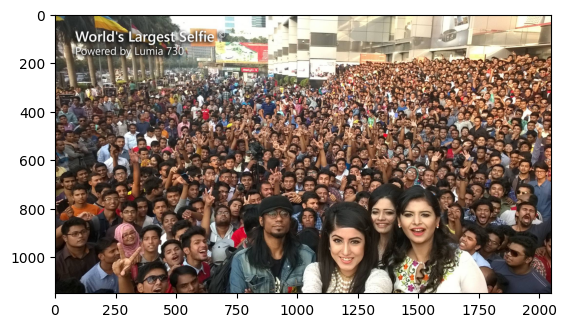

In [4]:
plt.imshow(im)
plt.show()

I'll cheat by using the built in Viola and Jones face detector from opencv to find faces in this image

In [5]:
# Load a pre-trained classifier
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

In [6]:
#Detect faces
gray_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
faces = face_detector.detectMultiScale(gray_im,1.1,4)

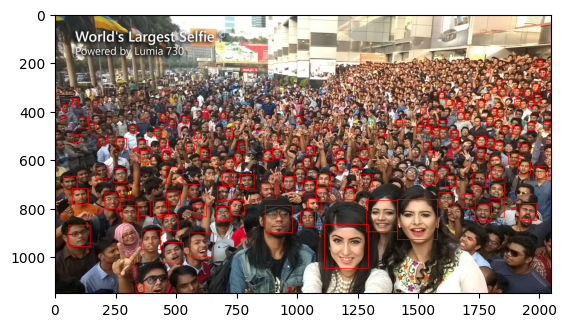

In [7]:
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(im, (x, y), (x+w, y+h), (255, 0, 0), 2)
# Display the output
plt.imshow(im)
plt.show()

Wow, that was easy - got quite a few faces. Nowhere near as many as with more modern state of the art detectors though. Anyway, Let's try and reverse engineer the classifier by using these faces as training data to train our own classifier.

In [8]:
# Crop and resize all the detected faces in the image
positive_training_examples = []
pos_labels = []
for (x, y, w, h) in faces:
    positive_training_examples.append(cv2.resize(gray_im[y:y+h,x:x+w],(20,20)))
    pos_labels.append(1)

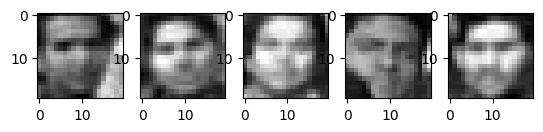

In [9]:
# Look at a few faces - always look at your training data
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(positive_training_examples[i],cmap='gray')
plt.show()

In [10]:
# Lets make some negative training examples by randomly cropping other parts of the image
negative_training_examples = []
neg_labels = []
for k in range(len(positive_training_examples)):
    i = np.random.randint(gray_im.shape[0]-20)
    j = np.random.randint(gray_im.shape[1]-20)
    negative_training_examples.append(gray_im[i:i+20,j:j+20])
    neg_labels.append(0)


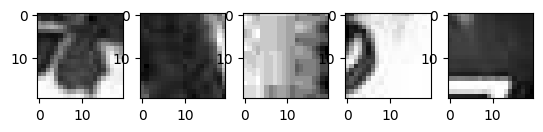

In [11]:
# Look at a few non-faces
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(negative_training_examples[i],cmap='gray')
plt.show()

Right now, these images have a bit too much variety in them, so lets extract some features using some special image filters called haar wavelets 

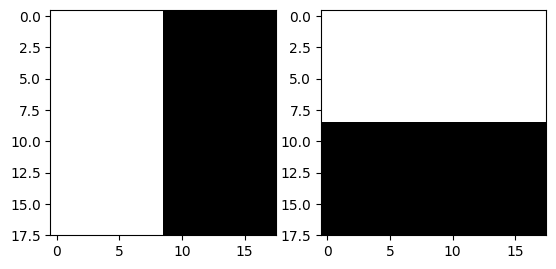

In [12]:
kernel_x = np.repeat(np.hstack((np.ones((1,9)),np.zeros((1,9)))),18,axis=0)/(18*18)
kernel_y = np.repeat(np.vstack((np.ones((9,1)),np.zeros((9,1)))),18,axis=1)/(18*18)

plt.subplot(1,2,1)
plt.imshow(kernel_x,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(kernel_y,cmap='gray')
plt.show()

### Activity

* You've seen filters a bit like this before, do you remember what they do?
* What do you think these filters will extract from an image of a face?

In [23]:
training_ims = negative_training_examples+positive_training_examples
training_labels = neg_labels+pos_labels

In [24]:
# Extract features
training_features = []
for im in training_ims:
    # Our features will be the filter responses to each of these operations, reshaped into a long vector and concatenated
    response_x = convolve2d(im.astype(np.float32),kernel_x,mode='valid').reshape(1,-1)
    response_y = convolve2d(im.astype(np.float32),kernel_y,mode='valid').reshape(1,-1)
    training_features.append(np.hstack((response_x,response_y)))
    
# Normalise features [0-1]
training_features = np.vstack(training_features)
norm_constant = np.max(training_features) # save this for later
training_features = training_features/norm_constant
    

In [15]:
# Split our dataset into a training portion and a validation portion
x_train,x_test,y_train,y_test = train_test_split(training_features,training_labels)

So we have split our training data into two portions. Let's visually look at these features we've extracted

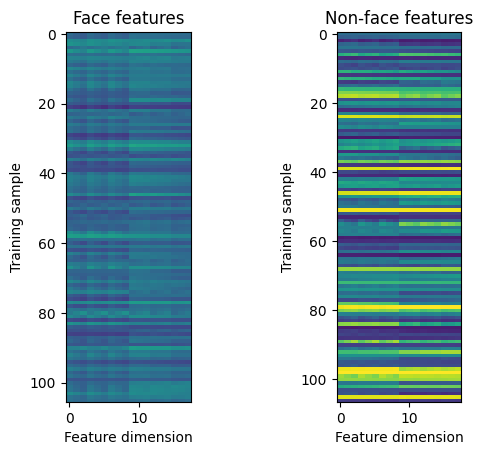

In [16]:
plt.subplot(1,2,1)
plt.imshow(np.vstack(x_train)[np.array(y_train)==1,:],vmin=0,vmax=1,aspect=0.5)
plt.ylabel('Training sample')
plt.xlabel('Feature dimension')
plt.title('Face features')
plt.subplot(1,2,2)
plt.imshow(np.vstack(x_train)[np.array(y_train)==0,:],vmin=0,vmax=1,aspect=0.5)
plt.title('Non-face features')
plt.ylabel('Training sample')
plt.xlabel('Feature dimension')
plt.show()

Interesting. I can visualy see differences between the filter response to faces and non-faces! Let's train a logistic regression classify using this data.

In [17]:
cls = LogisticRegression()
cls.fit(np.vstack(x_train),np.array(y_train))

LogisticRegression()

In [18]:
y_pred_train = cls.predict(np.vstack(x_train))
Accuracy = np.sum(y_pred_train==y_train)/len(y_train)
print("Training Accuracy: ", Accuracy)

y_pred_test = cls.predict(np.vstack(x_test))
Accuracy = np.sum(y_pred_test==y_test)/len(y_test)
print("Test Accuracy: ", Accuracy)
print(Accuracy*len(y_test),"out of",len(y_test),"unseen faces correctly detected")


Training Accuracy:  0.704225352112676
Test Accuracy:  0.704225352112676
50.0 out of 71 unseen faces correctly detected


So not incredible performance, but this is about the dumbest thing we can try to do, two giant hand crafted filters on some random faces pulled from a single selfie image and logistic regression recognises >70% of the faces we didn't show our classifier. Let's see if this works on my own face.

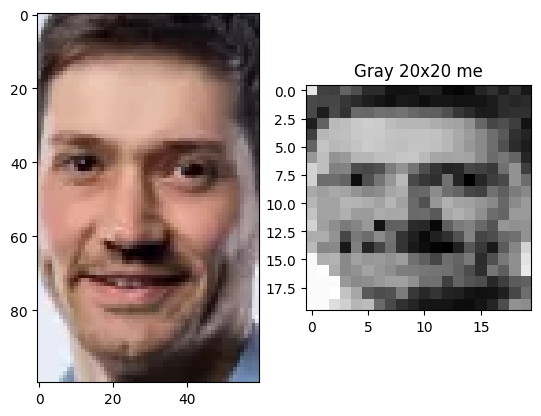

In [19]:
test_im = read_image_from_url('https://research.monash.edu/files-asset/329408228/mb.jpg?w=160&f=webp')[20:120,50:110,:]
# test_im = read_image_from_url('https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Anthony_Albanese_portrait_%28cropped%29.jpg/220px-Anthony_Albanese_portrait_%28cropped%29.jpg')[20:180,50:170,:]
plt.subplot(1,2,1)
plt.imshow(test_im)

plt.subplot(1,2,2)
gray_test_im = cv2.resize(cv2.cvtColor(test_im,cv2.COLOR_BGR2GRAY),(20,20))
plt.imshow(gray_test_im,cmap='gray')
plt.title('Gray 20x20 me')
plt.show()

In [20]:
# Extract features
response_x = convolve2d(gray_test_im.astype(np.float32),kernel_x,mode='valid').reshape(1,-1)
response_y = convolve2d(gray_test_im.astype(np.float32),kernel_y,mode='valid').reshape(1,-1)
test_feature = (np.hstack((response_x,response_y)))

# Normalise by training set norm factor - our features must be processed exactly the same way for the classifier!
test_feature = test_feature/norm_constant

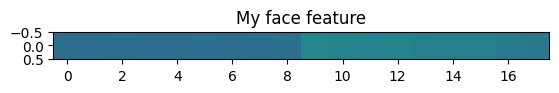

In [21]:
plt.imshow(test_feature,vmin=0,vmax=1)
plt.title('My face feature')
plt.show()

In [22]:
test_label = cls.predict(test_feature)
if test_label:
    print('This is a face.')
else:
    print('This is not a face.')

This is a face.


### Activity

* Try your own image and see if this dodgy face detector is really any good.
* This detect assumes we had cropped boxes around the faces already. What strategy would you use if you had an image without the face already cropped and centred?
* What kind of issues do you think our choice of training data would introduce if we tried to deploy this model?
* How would you improve this classifier?




